In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers[torch] datasets accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.wh

In [ ]:
import pandas as pd
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
import torch
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset


# **HYPERPARAMETER TUNING** via cross-fold validation

In [ ]:
model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

def tokenize(batch):
    return tokenizer(batch["lyrics"], padding=True, truncation=True, max_length=512)

In [ ]:
from datasets import load_dataset

val_ds = load_dataset("csv", data_files='/content/drive/MyDrive/CZ4034/final_labeled_lyrics_genre.csv', split=[f"train[{k}%:{k+20}%]" for k in range(0, 100, 20)])
train_ds = load_dataset("csv", data_files='/content/drive/MyDrive/CZ4034/final_labeled_lyrics_genre.csv', split=[f"train[:{k}%]+train[{k+20}%:]" for k in range(0, 100, 20)])
# val_ds, train_ds

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [8, 16, 32]
weight_decays = [0.0001, 0.001, 0.01]


# **OPTIMAL LEARNING RATE = 0.0001**

In [ ]:
# TEST LEARNING RATES
def find_optimal_hyperparameter(train_dataset, eval_dataset, parameters, mode):

    # train_dataset and eval_dataset already in folds
    cross_validation_accuracies = {}
    cross_validation_times = {}

    for p in parameters:
      print(f"{p} {mode}:")
      cross_validation_accuracies[p] = {}
      cross_validation_accuracies[p]['eval_loss'] = []
      cross_validation_accuracies[p]['train_loss'] = []
      cross_validation_accuracies[p]['eval_f1'] = []
      cross_validation_accuracies[p]['eval_acc'] = []
      cross_validation_accuracies[p]['eval_precision'] = []
      cross_validation_accuracies[p]['eval_recall'] = []
      times = []

      for i in range(5):
          # each fold
          model = (AutoModelForSequenceClassification
          .from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)
          .to(device))

          tokenized_train = train_dataset[i].map(tokenize, batched=True)
          tokenized_eval = eval_dataset[i].map(tokenize, batched=True)
          tokenized_train = tokenized_train.map(lambda x: {"label": label2id[x['emotion']]})
          tokenized_eval = tokenized_eval.map(lambda x: {"label": label2id[x['emotion']]})
          logging_steps = len(tokenized_train) // batch_size
          new_model = f"distilbert-lyrics-{i+1}"

          training_args = TrainingArguments(output_dir=new_model,
                                            num_train_epochs=no_epochs,
                                            learning_rate=p,
                                            per_device_train_batch_size=batch_size,
                                            per_device_eval_batch_size=batch_size,
                                            weight_decay=0.01,
                                            evaluation_strategy="epoch",
                                            save_strategy="epoch",
                                            disable_tqdm=False,
                                            logging_steps=logging_steps,
                                            log_level="error")

          trainer = Trainer(model=model, args=training_args,
                            compute_metrics=compute_metrics,
                            train_dataset=tokenized_train,
                            eval_dataset=tokenized_eval,
                            tokenizer=tokenizer
                            )
          trainer.train();
          train = trainer.state.log_history[:-1:2]
          eval = trainer.state.log_history[1:-1:2]
          cross_validation_accuracies[p]['train_loss'].append([e['loss'] for e in train])
          cross_validation_accuracies[p]['eval_loss'].append([e['eval_loss'] for e in eval])
          cross_validation_accuracies[p]['eval_f1'].append([e['eval_f1'] for e in eval])
          cross_validation_accuracies[p]['eval_acc'].append([e['eval_accuracy'] for e in eval])
          cross_validation_accuracies[p]['eval_precision'].append([e['eval_precision'] for e in eval])
          cross_validation_accuracies[p]['eval_recall'].append([e['eval_recall'] for e in eval])

      cross_validation_accuracies[p]['eval_loss'] = np.mean(cross_validation_accuracies[p]['eval_loss'], axis=0)
      cross_validation_accuracies[p]['train_loss'] = np.mean(cross_validation_accuracies[p]['train_loss'], axis=0)
      cross_validation_accuracies[p]['eval_f1'] = np.mean(cross_validation_accuracies[p]['eval_f1'], axis=0)
      cross_validation_accuracies[p]['eval_acc'] = np.mean(cross_validation_accuracies[p]['eval_acc'], axis=0)
      cross_validation_accuracies[p]['eval_precision'] = np.mean(cross_validation_accuracies[p]['eval_precision'], axis=0)
      cross_validation_accuracies[p]['eval_recall'] = np.mean(cross_validation_accuracies[p]['eval_recall'], axis=0)
      # print(f"mean cross-validation loss = {cross_validation_accuracies[p]['eval_loss'][-1]*100:.2f}%")
      # print(f"mean eval_f1 = {cross_validation_accuracies[p]['eval_f1'][-1]*100:.2f}%")
      # print(f"mean eval_acc = {cross_validation_accuracies[p]['eval_acc'][-1]*100:.2f}%")
      # print(f"mean eval_precision = {cross_validation_accuracies[p]['eval_precision'][-1]*100:.2f}%")
      # print(f"mean eval_recall = {cross_validation_accuracies[p]['eval_recall'][-1]*100:.2f}%")


    return cross_validation_accuracies

no_epochs = 5
batch_size = 16
mode = 'learning_rate'
cross_validation_accuracies = find_optimal_hyperparameter(train_ds, val_ds, learning_rates, mode)
cross_validation_accuracies

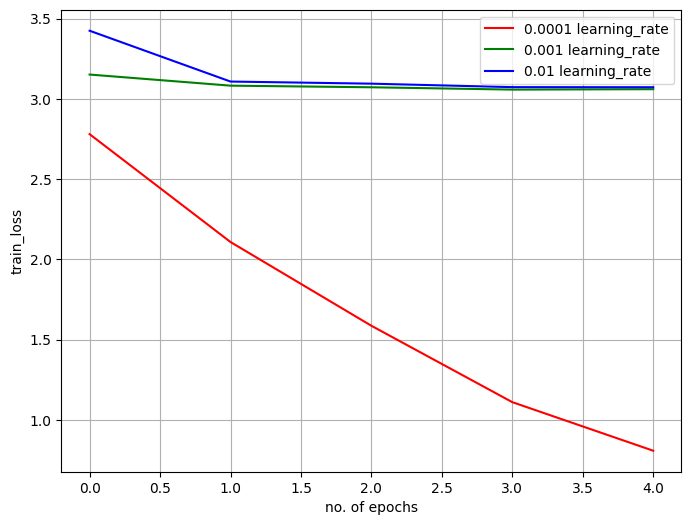

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(8, 6))
c = ['red','green','blue','black','yellow']
for idx, p in enumerate(learning_rates):
    plt.plot(range(no_epochs), cross_validation_accuracies[p]['train_loss'], color=c[idx], label=f'{p} learning_rate')
plt.xlabel('no. of epochs')
plt.ylabel('train_loss')
plt.legend()
plt.grid(True)
plt.show()

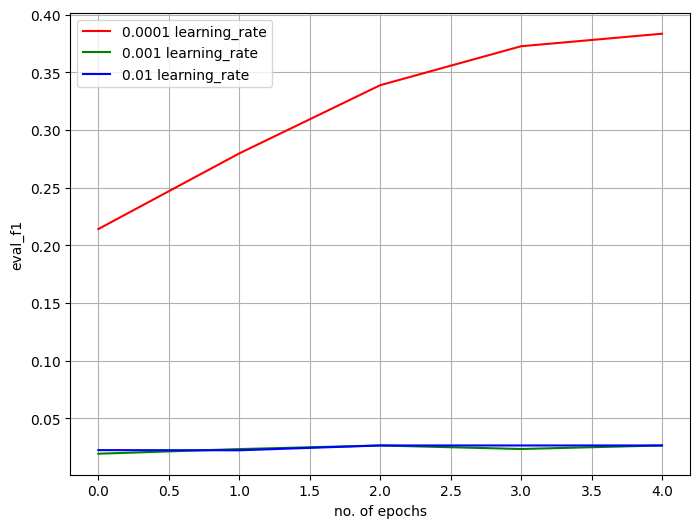

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(8, 6))
c = ['red','green','blue','black','yellow']
for idx, p in enumerate(learning_rates):
    plt.plot(range(no_epochs), cross_validation_accuracies[p]['eval_f1'], color=c[idx], label=f'{p} learning_rate')
plt.xlabel('no. of epochs')
plt.ylabel('eval_f1')
plt.legend()
plt.grid(True)
plt.show()

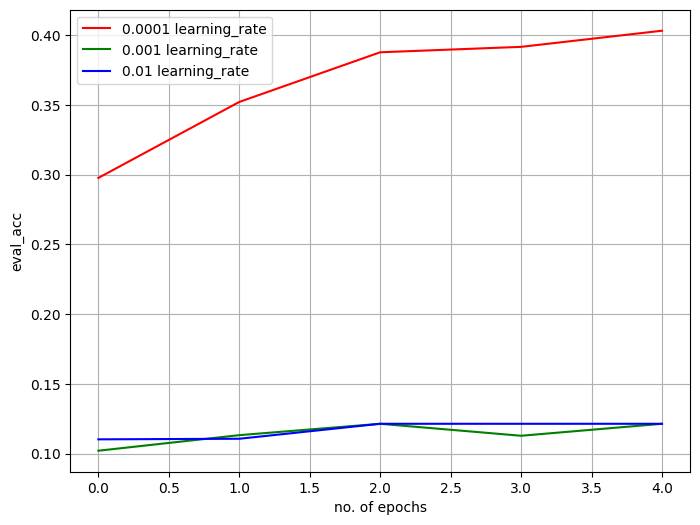

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(8, 6))
c = ['red','green','blue','black','yellow']
for idx, p in enumerate(learning_rates):
    plt.plot(range(no_epochs), cross_validation_accuracies[p]['eval_acc'], color=c[idx], label=f'{p} learning_rate')
plt.xlabel('no. of epochs')
plt.ylabel('eval_acc')
plt.legend()
plt.grid(True)
plt.show()

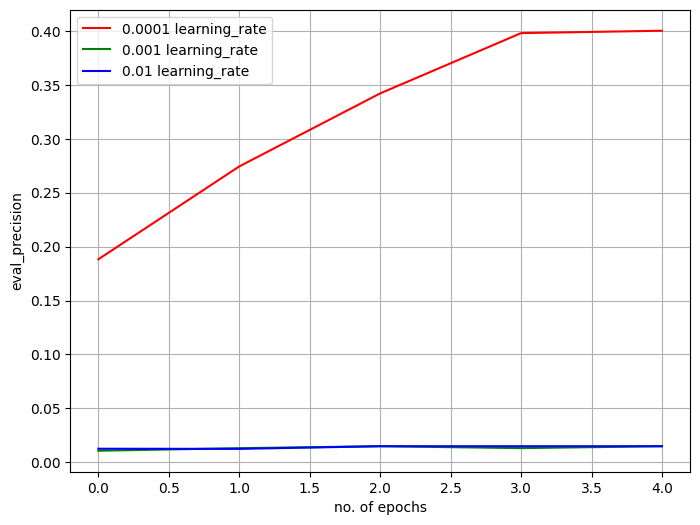

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(8, 6))
c = ['red','green','blue','black','yellow']
for idx, p in enumerate(learning_rates):
    plt.plot(range(no_epochs), cross_validation_accuracies[p]['eval_precision'], color=c[idx], label=f'{p} learning_rate')
plt.xlabel('no. of epochs')
plt.ylabel('eval_precision')
plt.legend()
plt.grid(True)
plt.show()

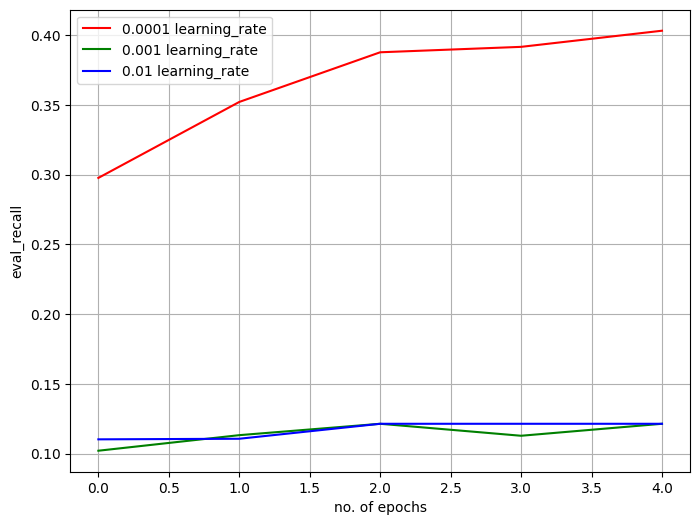

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(8, 6))
c = ['red','green','blue','black','yellow']
for idx, p in enumerate(learning_rates):
    plt.plot(range(no_epochs), cross_validation_accuracies[p]['eval_recall'], color=c[idx], label=f'{p} learning_rate')
plt.xlabel('no. of epochs')
plt.ylabel('eval_recall')
plt.legend()
plt.grid(True)
plt.show()

# **NO OPTIMAL BATCH SIZE**

In [ ]:
# TEST LEARNING RATES
def find_optimal_hyperparameter(train_dataset, eval_dataset, parameters, mode):

    # train_dataset and eval_dataset already in folds
    cross_validation_accuracies = {}
    cross_validation_times = {}

    for p in parameters:
      print(f"{p} {mode}:")
      cross_validation_accuracies[p] = {}
      cross_validation_accuracies[p]['eval_loss'] = []
      cross_validation_accuracies[p]['train_loss'] = []
      cross_validation_accuracies[p]['eval_f1'] = []
      cross_validation_accuracies[p]['eval_acc'] = []
      cross_validation_accuracies[p]['eval_precision'] = []
      cross_validation_accuracies[p]['eval_recall'] = []
      times = []

      for i in range(5):
          # each fold
          model = (AutoModelForSequenceClassification
          .from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)
          .to(device))

          tokenized_train = train_dataset[i].map(tokenize, batched=True)
          tokenized_eval = eval_dataset[i].map(tokenize, batched=True)
          tokenized_train = tokenized_train.map(lambda x: {"label": label2id[x['emotion']]})
          tokenized_eval = tokenized_eval.map(lambda x: {"label": label2id[x['emotion']]})
          logging_steps = len(tokenized_train) // p
          new_model = f"distilbert-lyrics-{i+1}"

          training_args = TrainingArguments(output_dir=new_model,
                                            num_train_epochs=no_epochs,
                                            learning_rate=0.0001,
                                            per_device_train_batch_size=p,
                                            per_device_eval_batch_size=p,
                                            weight_decay=0.01,
                                            evaluation_strategy="epoch",
                                            save_strategy="epoch",
                                            disable_tqdm=False,
                                            logging_steps=logging_steps,
                                            log_level="error")

          trainer = Trainer(model=model, args=training_args,
                            compute_metrics=compute_metrics,
                            train_dataset=tokenized_train,
                            eval_dataset=tokenized_eval,
                            tokenizer=tokenizer
                            )
          trainer.train();
          train = trainer.state.log_history[:-1:2]
          eval = trainer.state.log_history[1:-1:2]
          cross_validation_accuracies[p]['train_loss'].append([e['loss'] for e in train])
          cross_validation_accuracies[p]['eval_loss'].append([e['eval_loss'] for e in eval])
          cross_validation_accuracies[p]['eval_f1'].append([e['eval_f1'] for e in eval])
          cross_validation_accuracies[p]['eval_acc'].append([e['eval_accuracy'] for e in eval])
          cross_validation_accuracies[p]['eval_precision'].append([e['eval_precision'] for e in eval])
          cross_validation_accuracies[p]['eval_recall'].append([e['eval_recall'] for e in eval])

      cross_validation_accuracies[p]['eval_loss'] = np.mean(cross_validation_accuracies[p]['eval_loss'], axis=0)
      cross_validation_accuracies[p]['train_loss'] = np.mean(cross_validation_accuracies[p]['train_loss'], axis=0)
      cross_validation_accuracies[p]['eval_f1'] = np.mean(cross_validation_accuracies[p]['eval_f1'], axis=0)
      cross_validation_accuracies[p]['eval_acc'] = np.mean(cross_validation_accuracies[p]['eval_acc'], axis=0)
      cross_validation_accuracies[p]['eval_precision'] = np.mean(cross_validation_accuracies[p]['eval_precision'], axis=0)
      cross_validation_accuracies[p]['eval_recall'] = np.mean(cross_validation_accuracies[p]['eval_recall'], axis=0)
      # print(f"mean cross-validation loss = {cross_validation_accuracies[p]['eval_loss'][-1]*100:.2f}%")
      # print(f"mean eval_f1 = {cross_validation_accuracies[p]['eval_f1'][-1]*100:.2f}%")
      # print(f"mean eval_acc = {cross_validation_accuracies[p]['eval_acc'][-1]*100:.2f}%")
      # print(f"mean eval_precision = {cross_validation_accuracies[p]['eval_precision'][-1]*100:.2f}%")
      # print(f"mean eval_recall = {cross_validation_accuracies[p]['eval_recall'][-1]*100:.2f}%")


    return cross_validation_accuracies

no_epochs = 5
mode = 'batch_size'
cross_validation_accuracies = find_optimal_hyperparameter(train_ds, val_ds, batch_sizes, mode)

8 batch_size:


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1866 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Map:   0%|          | 0/1866 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.797600,2.637187,0.221030,0.166973,0.148986,0.221030
2,2.238600,2.457355,0.287554,0.235669,0.232478,0.287554
3,1.662300,2.310528,0.349785,0.310676,0.368201,0.349785
4,1.173200,2.191671,0.379828,0.362803,0.368672,0.379828
5,0.831500,2.244572,0.379828,0.366552,0.370412,0.379828


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Map:   0%|          | 0/1865 [00:00<?, ? examples/s]

Map:   0%|          | 0/467 [00:00<?, ? examples/s]

Map:   0%|          | 0/1865 [00:00<?, ? examples/s]

Map:   0%|          | 0/467 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.696000,2.455577,0.306210,0.230104,0.219513,0.306210
2,2.018700,2.266865,0.325482,0.266467,0.253279,0.325482
3,1.503800,2.194697,0.376874,0.335775,0.313413,0.376874
4,1.016200,2.258536,0.359743,0.339703,0.390675,0.359743
5,0.691800,2.343640,0.349036,0.332231,0.367006,0.349036


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Map:   0%|          | 0/1866 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Map:   0%|          | 0/1866 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.786800,2.682281,0.240343,0.165930,0.151815,0.240343
2,2.158200,2.288383,0.347639,0.279933,0.340819,0.347639
3,1.566800,2.320867,0.341202,0.306997,0.338308,0.341202
4,1.031500,2.255504,0.381974,0.366507,0.398605,0.381974
5,0.691800,2.227829,0.401288,0.385077,0.398297,0.401288


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Map:   0%|          | 0/1865 [00:00<?, ? examples/s]

Map:   0%|          | 0/467 [00:00<?, ? examples/s]

Map:   0%|          | 0/1865 [00:00<?, ? examples/s]

Map:   0%|          | 0/467 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.818800,2.319489,0.306210,0.189829,0.187438,0.306210
2,2.208400,2.078808,0.372591,0.319391,0.328096,0.372591
3,1.656800,1.943277,0.432548,0.383851,0.363242,0.432548
4,1.158900,1.945747,0.415418,0.401501,0.446348,0.415418
5,0.805900,1.921799,0.436831,0.426823,0.448475,0.436831


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Map:   0%|          | 0/1866 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Map:   0%|          | 0/1866 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.746000,2.752494,0.236052,0.133721,0.102794,0.236052
2,2.217800,2.482411,0.302575,0.228621,0.219959,0.302575
3,1.736600,2.428088,0.306867,0.234191,0.224786,0.306867
4,1.241500,2.443280,0.332618,0.314958,0.347316,0.332618
5,0.865700,2.446894,0.339056,0.319578,0.317050,0.339056


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

16 batch_size:


Map:   0%|          | 0/1866 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Map:   0%|          | 0/1866 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.842300,2.587761,0.246781,0.166727,0.141343,0.246781
2,2.258500,2.496962,0.270386,0.224544,0.218475,0.270386
3,1.752200,2.344963,0.343348,0.313894,0.353054,0.343348
4,1.250700,2.168535,0.379828,0.354092,0.352003,0.379828
5,0.966200,2.163390,0.369099,0.339658,0.333626,0.369099


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.801600,2.542131,0.256959,0.174413,0.139138,0.256959
2,2.088500,2.188288,0.366167,0.298510,0.278408,0.366167
3,1.572900,2.146674,0.374732,0.330587,0.308566,0.374732
4,1.120700,2.198709,0.334047,0.306422,0.383019,0.334047
5,0.838100,2.155706,0.376874,0.360941,0.417489,0.376874


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.822500,2.442780,0.336910,0.253834,0.247026,0.336910
2,2.135500,2.248970,0.369099,0.287956,0.289456,0.369099
3,1.616700,2.136099,0.390558,0.349882,0.390860,0.390558
4,1.130300,2.140706,0.405579,0.388000,0.411302,0.405579
5,0.832100,2.112775,0.407725,0.382818,0.407172,0.407725


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precis

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.822500,2.220565,0.376874,0.286101,0.263501,0.376874
2,2.139100,1.970206,0.413276,0.356969,0.357654,0.413276
3,1.559100,1.802228,0.453961,0.413432,0.411619,0.453961
4,1.080500,1.807868,0.432548,0.420670,0.436931,0.432548
5,0.764500,1.789628,0.449679,0.440564,0.448670,0.449679


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.720900,2.693542,0.231760,0.152452,0.119154,0.231760
2,2.129400,2.525388,0.296137,0.207182,0.211097,0.296137
3,1.650900,2.294386,0.347639,0.274589,0.278408,0.347639
4,1.170400,2.348988,0.354077,0.332697,0.331614,0.354077
5,0.842600,2.321598,0.371245,0.339579,0.331982,0.371245


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

32 batch_size:


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.872700,2.588088,0.248927,0.164426,0.142797,0.248927
2,2.229300,2.392432,0.302575,0.245838,0.241366,0.302575
3,1.752700,2.231669,0.356223,0.300893,0.290247,0.356223
4,1.316200,2.066564,0.405579,0.359250,0.358147,0.405579
5,1.059300,2.044280,0.409871,0.371003,0.357328,0.409871


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.917400,2.593460,0.284797,0.182794,0.148038,0.284797
2,2.249000,2.246022,0.327623,0.260534,0.243341,0.327623
3,1.718000,2.098097,0.391863,0.349768,0.369289,0.391863
4,1.299100,2.089242,0.344754,0.299875,0.314933,0.344754
5,1.045400,1.986669,0.408994,0.373178,0.382681,0.408994


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.878100,2.517044,0.328326,0.249381,0.237036,0.328326
2,2.233600,2.363923,0.326180,0.239366,0.237105,0.326180
3,1.766100,2.065078,0.396996,0.333860,0.303458,0.396996
4,1.286200,1.999580,0.388412,0.348858,0.382054,0.388412
5,1.039000,1.991989,0.405579,0.360862,0.394466,0.405579


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.920000,2.303274,0.389722,0.285078,0.270993,0.389722
2,2.252700,1.965799,0.426124,0.354439,0.355417,0.426124
3,1.723300,1.852143,0.428266,0.394281,0.430911,0.428266
4,1.311500,1.847212,0.426124,0.405561,0.410513,0.426124
5,1.056300,1.761538,0.468951,0.451640,0.467350,0.468951


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.823600,2.719255,0.253219,0.143472,0.142538,0.253219
2,2.182700,2.531182,0.274678,0.190498,0.162340,0.274678
3,1.712200,2.273903,0.324034,0.256671,0.248275,0.324034
4,1.283700,2.257500,0.339056,0.304015,0.297423,0.339056
5,1.013400,2.230629,0.339056,0.300068,0.302937,0.339056


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

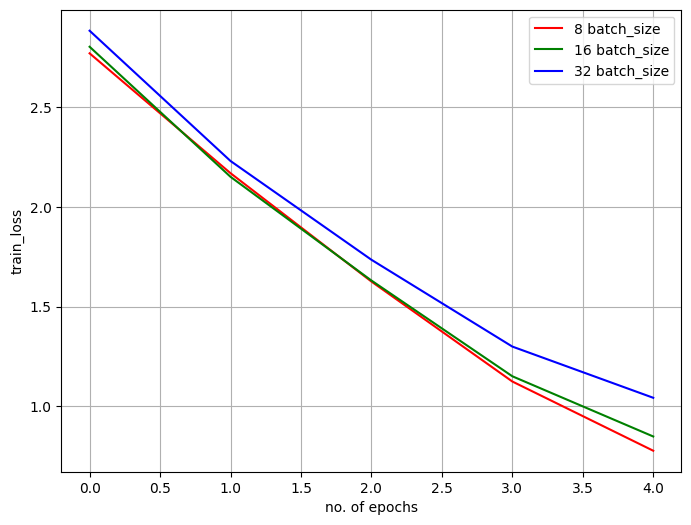

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(8, 6))
c = ['red','green','blue','black','yellow']
for idx, p in enumerate(batch_sizes):
    plt.plot(range(no_epochs), cross_validation_accuracies[p]['train_loss'], color=c[idx], label=f'{p} {mode}')
plt.xlabel('no. of epochs')
plt.ylabel('train_loss')
plt.legend()
plt.grid(True)
plt.show()

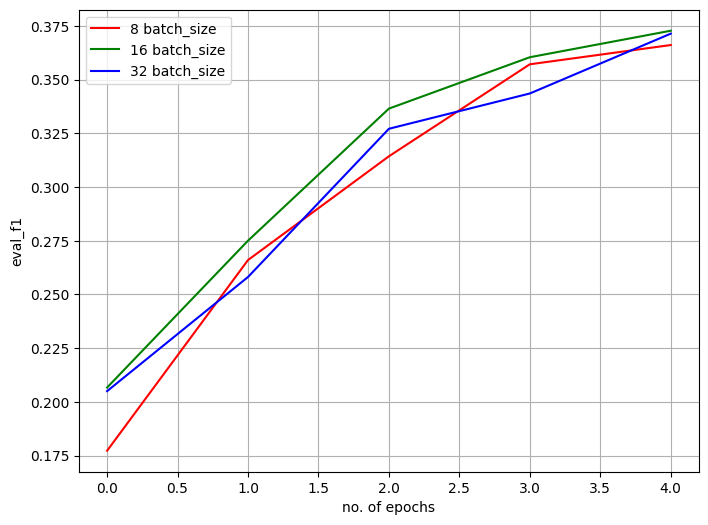

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(8, 6))
c = ['red','green','blue','black','yellow']
for idx, p in enumerate(batch_sizes):
    plt.plot(range(no_epochs), cross_validation_accuracies[p]['eval_f1'], color=c[idx], label=f'{p} {mode}')
plt.xlabel('no. of epochs')
plt.ylabel('eval_f1')
plt.legend()
plt.grid(True)
plt.show()

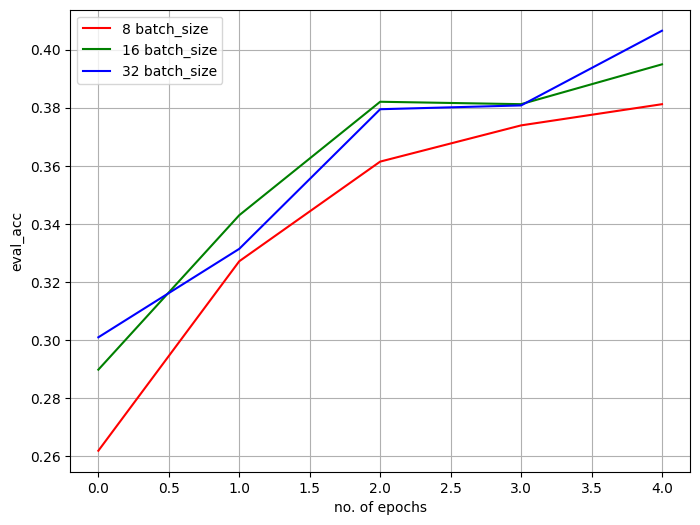

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(8, 6))
c = ['red','green','blue','black','yellow']
for idx, p in enumerate(batch_sizes):
    plt.plot(range(no_epochs), cross_validation_accuracies[p]['eval_acc'], color=c[idx], label=f'{p} {mode}')
plt.xlabel('no. of epochs')
plt.ylabel('eval_acc')
plt.legend()
plt.grid(True)
plt.show()

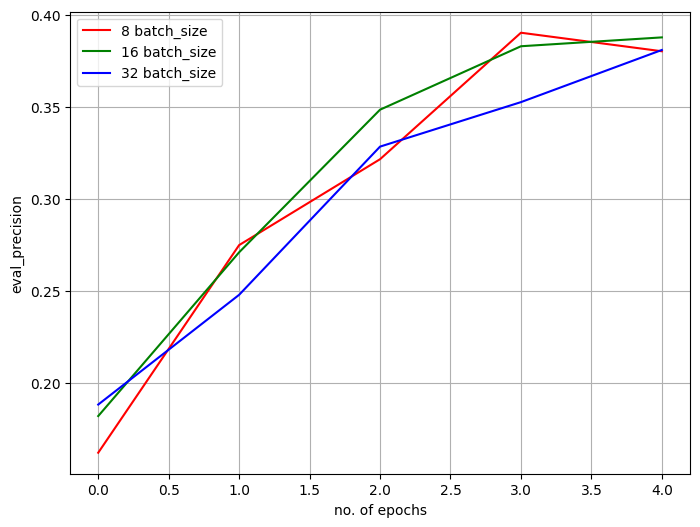

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(8, 6))
c = ['red','green','blue','black','yellow']
for idx, p in enumerate(batch_sizes):
    plt.plot(range(no_epochs), cross_validation_accuracies[p]['eval_precision'], color=c[idx], label=f'{p} {mode}')
plt.xlabel('no. of epochs')
plt.ylabel('eval_precision')
plt.legend()
plt.grid(True)
plt.show()

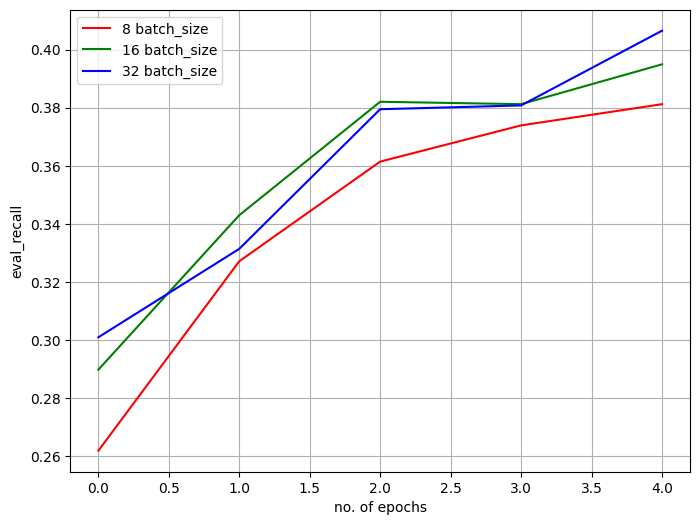

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(8, 6))
c = ['red','green','blue','black','yellow']
for idx, p in enumerate(batch_sizes):
    plt.plot(range(no_epochs), cross_validation_accuracies[p]['eval_recall'], color=c[idx], label=f'{p} {mode}')
plt.xlabel('no. of epochs')
plt.ylabel('eval_recall')
plt.legend()
plt.grid(True)
plt.show()

# **OPTIMAL WEIGHT DECAY = 0.0001**

In [ ]:
# TEST LEARNING RATES
def find_optimal_hyperparameter(train_dataset, eval_dataset, parameters, mode):

    # train_dataset and eval_dataset already in folds
    cross_validation_accuracies = {}
    cross_validation_times = {}

    for p in parameters:
      print(f"{p} {mode}:")
      cross_validation_accuracies[p] = {}
      cross_validation_accuracies[p]['eval_loss'] = []
      cross_validation_accuracies[p]['train_loss'] = []
      cross_validation_accuracies[p]['eval_f1'] = []
      cross_validation_accuracies[p]['eval_acc'] = []
      cross_validation_accuracies[p]['eval_precision'] = []
      cross_validation_accuracies[p]['eval_recall'] = []
      times = []

      for i in range(5):
          # each fold
          model = (AutoModelForSequenceClassification
          .from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)
          .to(device))

          tokenized_train = train_dataset[i].map(tokenize, batched=True)
          tokenized_eval = eval_dataset[i].map(tokenize, batched=True)
          tokenized_train = tokenized_train.map(lambda x: {"label": label2id[x['emotion']]})
          tokenized_eval = tokenized_eval.map(lambda x: {"label": label2id[x['emotion']]})
          logging_steps = len(tokenized_train) // batch_size
          new_model = f"distilbert-lyrics-{i+1}"

          training_args = TrainingArguments(output_dir=new_model,
                                            num_train_epochs=no_epochs,
                                            learning_rate=0.0001,
                                            per_device_train_batch_size=batch_size,
                                            per_device_eval_batch_size=batch_size,
                                            weight_decay=p,
                                            evaluation_strategy="epoch",
                                            save_strategy="epoch",
                                            disable_tqdm=False,
                                            logging_steps=logging_steps,
                                            log_level="error")

          trainer = Trainer(model=model, args=training_args,
                            compute_metrics=compute_metrics,
                            train_dataset=tokenized_train,
                            eval_dataset=tokenized_eval,
                            tokenizer=tokenizer
                            )
          trainer.train();
          train = trainer.state.log_history[:-1:2]
          eval = trainer.state.log_history[1:-1:2]
          cross_validation_accuracies[p]['train_loss'].append([e['loss'] for e in train])
          cross_validation_accuracies[p]['eval_loss'].append([e['eval_loss'] for e in eval])
          cross_validation_accuracies[p]['eval_f1'].append([e['eval_f1'] for e in eval])
          cross_validation_accuracies[p]['eval_acc'].append([e['eval_accuracy'] for e in eval])
          cross_validation_accuracies[p]['eval_precision'].append([e['eval_precision'] for e in eval])
          cross_validation_accuracies[p]['eval_recall'].append([e['eval_recall'] for e in eval])

      cross_validation_accuracies[p]['eval_loss'] = np.mean(cross_validation_accuracies[p]['eval_loss'], axis=0)
      cross_validation_accuracies[p]['train_loss'] = np.mean(cross_validation_accuracies[p]['train_loss'], axis=0)
      cross_validation_accuracies[p]['eval_f1'] = np.mean(cross_validation_accuracies[p]['eval_f1'], axis=0)
      cross_validation_accuracies[p]['eval_acc'] = np.mean(cross_validation_accuracies[p]['eval_acc'], axis=0)
      cross_validation_accuracies[p]['eval_precision'] = np.mean(cross_validation_accuracies[p]['eval_precision'], axis=0)
      cross_validation_accuracies[p]['eval_recall'] = np.mean(cross_validation_accuracies[p]['eval_recall'], axis=0)
      # print(f"mean cross-validation loss = {cross_validation_accuracies[p]['eval_loss'][-1]*100:.2f}%")
      # print(f"mean eval_f1 = {cross_validation_accuracies[p]['eval_f1'][-1]*100:.2f}%")
      # print(f"mean eval_acc = {cross_validation_accuracies[p]['eval_acc'][-1]*100:.2f}%")
      # print(f"mean eval_precision = {cross_validation_accuracies[p]['eval_precision'][-1]*100:.2f}%")
      # print(f"mean eval_recall = {cross_validation_accuracies[p]['eval_recall'][-1]*100:.2f}%")


    return cross_validation_accuracies

no_epochs = 5
batch_size = 16
mode = 'weight_decay'
cross_validation_accuracies = find_optimal_hyperparameter(train_ds, val_ds, weight_decays, mode)

0.0001 weight_decay:


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1866 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Map:   0%|          | 0/1866 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.728600,2.467774,0.285408,0.204695,0.195403,0.285408
2,2.058500,2.259593,0.332618,0.278175,0.269939,0.332618
3,1.497100,2.156307,0.375536,0.325423,0.356665,0.375536
4,1.009600,2.054406,0.416309,0.399385,0.420342,0.416309
5,0.723000,2.059977,0.448498,0.428499,0.431690,0.448498


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Map:   0%|          | 0/1865 [00:00<?, ? examples/s]

Map:   0%|          | 0/467 [00:00<?, ? examples/s]

Map:   0%|          | 0/1865 [00:00<?, ? examples/s]

Map:   0%|          | 0/467 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.800000,2.544566,0.269807,0.185755,0.149910,0.269807
2,2.089200,2.182348,0.364026,0.299368,0.281618,0.364026
3,1.573800,2.132477,0.374732,0.330678,0.312857,0.374732
4,1.118200,2.187538,0.346895,0.316520,0.351432,0.346895
5,0.837400,2.149251,0.368308,0.349461,0.417482,0.368308


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Map:   0%|          | 0/1866 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Map:   0%|          | 0/1866 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.823000,2.410682,0.339056,0.256992,0.240909,0.339056
2,2.120400,2.222083,0.379828,0.297892,0.272707,0.379828
3,1.583100,2.133009,0.390558,0.345756,0.372770,0.390558
4,1.105800,2.109247,0.412017,0.394361,0.406147,0.412017
5,0.816600,2.109277,0.396996,0.370441,0.387451,0.396996


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Map:   0%|          | 0/1865 [00:00<?, ? examples/s]

Map:   0%|          | 0/467 [00:00<?, ? examples/s]

Map:   0%|          | 0/1865 [00:00<?, ? examples/s]

Map:   0%|          | 0/467 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.818400,2.262443,0.368308,0.285307,0.282955,0.368308
2,2.128300,1.917058,0.428266,0.366667,0.352767,0.428266
3,1.542600,1.781771,0.451820,0.413677,0.407299,0.451820
4,1.048600,1.807102,0.456103,0.439794,0.453028,0.456103
5,0.740900,1.768921,0.458244,0.448598,0.467864,0.458244


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Map:   0%|          | 0/1866 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Map:   0%|          | 0/1866 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.726500,2.716379,0.231760,0.147975,0.128809,0.231760
2,2.158300,2.524278,0.298283,0.207674,0.184059,0.298283
3,1.646000,2.287951,0.347639,0.285070,0.267694,0.347639
4,1.172500,2.395111,0.345494,0.332545,0.361726,0.345494
5,0.845700,2.328772,0.373391,0.345785,0.342046,0.373391


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

0.001 weight_decay:


Map:   0%|          | 0/1866 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Map:   0%|          | 0/1866 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.838800,2.608943,0.238197,0.156288,0.145552,0.238197
2,2.246700,2.410116,0.285408,0.226995,0.212217,0.285408
3,1.715500,2.347194,0.317597,0.293390,0.308442,0.317597
4,1.222400,2.154492,0.388412,0.360921,0.365007,0.388412
5,0.945800,2.177375,0.364807,0.339774,0.335984,0.364807


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.799800,2.545408,0.269807,0.185585,0.151022,0.269807
2,2.087100,2.185135,0.364026,0.297891,0.285495,0.364026
3,1.572500,2.126858,0.376874,0.333513,0.321529,0.376874
4,1.121600,2.189954,0.342612,0.312415,0.349230,0.342612
5,0.837700,2.146418,0.372591,0.349114,0.405584,0.372591


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.825000,2.403016,0.324034,0.237398,0.199444,0.324034
2,2.130900,2.280778,0.351931,0.268909,0.245731,0.351931
3,1.615600,2.096452,0.396996,0.351381,0.405621,0.396996
4,1.139300,2.103783,0.403433,0.380054,0.391030,0.403433
5,0.842000,2.098742,0.414163,0.382711,0.411892,0.414163


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.818100,2.261887,0.368308,0.280408,0.274569,0.368308
2,2.128200,1.918528,0.438972,0.377376,0.357687,0.438972
3,1.543200,1.795414,0.447537,0.406964,0.404951,0.447537
4,1.055700,1.819659,0.453961,0.440843,0.464753,0.453961
5,0.748800,1.773859,0.460385,0.451674,0.470178,0.460385


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.717900,2.698646,0.225322,0.144269,0.125779,0.225322
2,2.120900,2.504297,0.298283,0.214971,0.197689,0.298283
3,1.628300,2.345123,0.319742,0.264222,0.279617,0.319742
4,1.153900,2.390901,0.319742,0.308510,0.338128,0.319742
5,0.832700,2.310281,0.386266,0.353127,0.342660,0.386266


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

0.01 weight_decay:


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.842300,2.587761,0.246781,0.166727,0.141343,0.246781
2,2.258500,2.496962,0.270386,0.224544,0.218475,0.270386
3,1.752200,2.344963,0.343348,0.313894,0.353054,0.343348
4,1.250700,2.168535,0.379828,0.354092,0.352003,0.379828
5,0.966200,2.163390,0.369099,0.339658,0.333626,0.369099


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.801600,2.542131,0.256959,0.174413,0.139138,0.256959
2,2.088500,2.188288,0.366167,0.298510,0.278408,0.366167
3,1.572900,2.146674,0.374732,0.330587,0.308566,0.374732
4,1.120700,2.198709,0.334047,0.306422,0.383019,0.334047
5,0.838100,2.155706,0.376874,0.360941,0.417489,0.376874


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.822500,2.442780,0.336910,0.253834,0.247026,0.336910
2,2.135500,2.248970,0.369099,0.287956,0.289456,0.369099
3,1.616700,2.136099,0.390558,0.349882,0.390860,0.390558
4,1.130300,2.140706,0.405579,0.388000,0.411302,0.405579
5,0.832100,2.112775,0.407725,0.382818,0.407172,0.407725


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precis

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.822500,2.220565,0.376874,0.286101,0.263501,0.376874
2,2.139100,1.970206,0.413276,0.356969,0.357654,0.413276
3,1.559100,1.802228,0.453961,0.413432,0.411619,0.453961
4,1.080500,1.807868,0.432548,0.420670,0.436931,0.432548
5,0.764500,1.789628,0.449679,0.440564,0.448670,0.449679


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.720900,2.693542,0.231760,0.152452,0.119154,0.231760
2,2.129400,2.525388,0.296137,0.207182,0.211097,0.296137
3,1.650900,2.294386,0.347639,0.274589,0.278408,0.347639
4,1.170400,2.348988,0.354077,0.332697,0.331614,0.354077
5,0.842600,2.321598,0.371245,0.339579,0.331982,0.371245


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

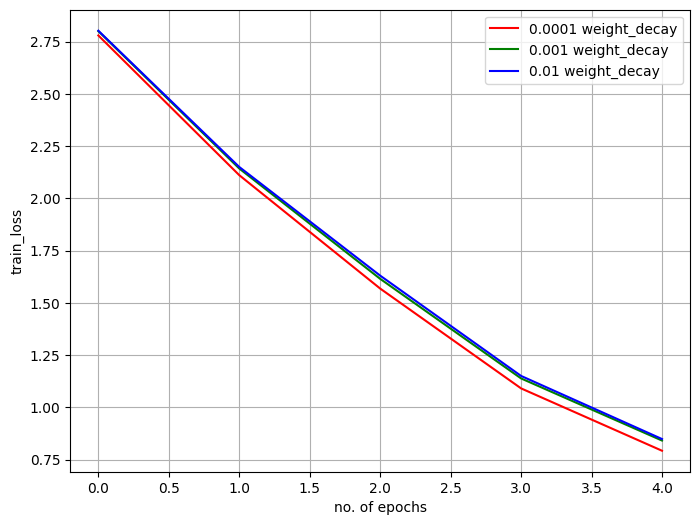

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(8, 6))
c = ['red','green','blue','black','yellow']
for idx, p in enumerate(weight_decays):
    plt.plot(range(no_epochs), cross_validation_accuracies[p]['train_loss'], color=c[idx], label=f'{p} {mode}')
plt.xlabel('no. of epochs')
plt.ylabel('train_loss')
plt.legend()
plt.grid(True)
plt.show()

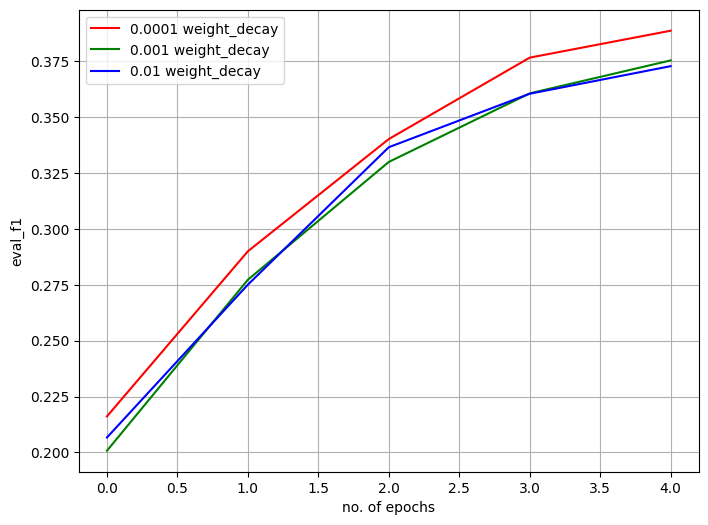

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(8, 6))
c = ['red','green','blue','black','yellow']
for idx, p in enumerate(weight_decays):
    plt.plot(range(no_epochs), cross_validation_accuracies[p]['eval_f1'], color=c[idx], label=f'{p} {mode}')
plt.xlabel('no. of epochs')
plt.ylabel('eval_f1')
plt.legend()
plt.grid(True)
plt.show()

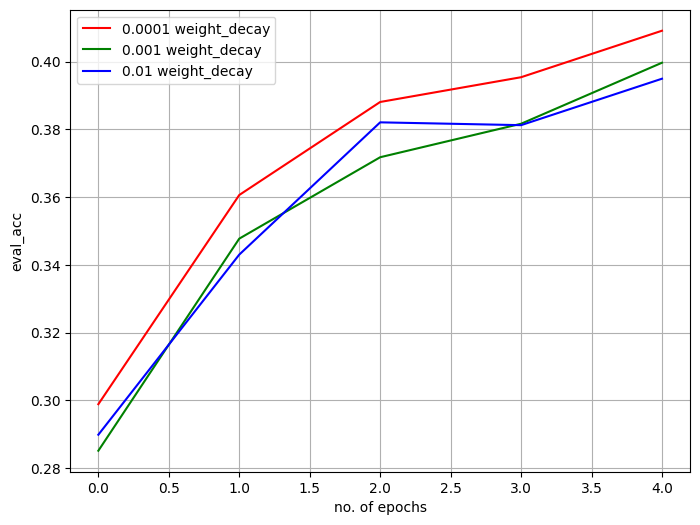

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(8, 6))
c = ['red','green','blue','black','yellow']
for idx, p in enumerate(weight_decays):
    plt.plot(range(no_epochs), cross_validation_accuracies[p]['eval_acc'], color=c[idx], label=f'{p} {mode}')
plt.xlabel('no. of epochs')
plt.ylabel('eval_acc')
plt.legend()
plt.grid(True)
plt.show()

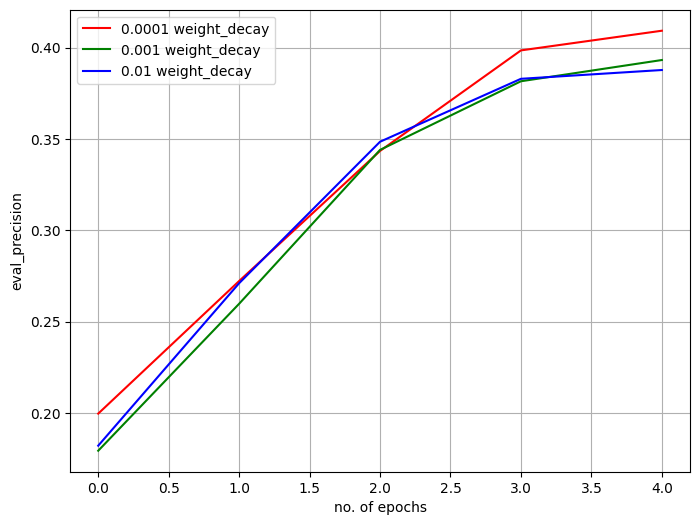

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(8, 6))
c = ['red','green','blue','black','yellow']
for idx, p in enumerate(weight_decays):
    plt.plot(range(no_epochs), cross_validation_accuracies[p]['eval_precision'], color=c[idx], label=f'{p} {mode}')
plt.xlabel('no. of epochs')
plt.ylabel('eval_precision')
plt.legend()
plt.grid(True)
plt.show()

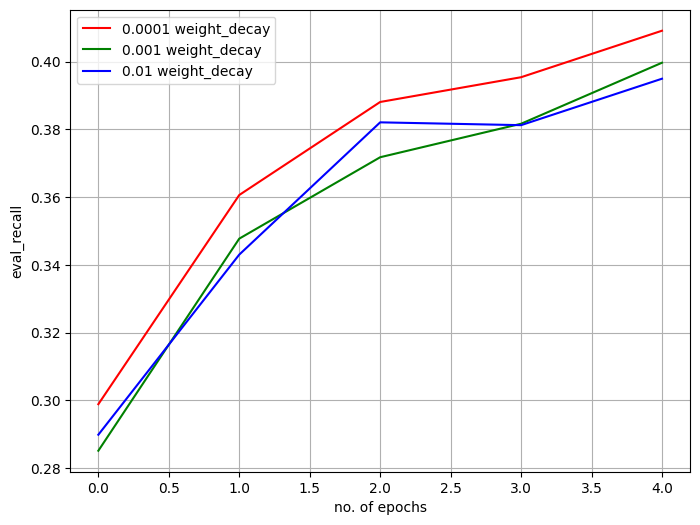

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(8, 6))
c = ['red','green','blue','black','yellow']
for idx, p in enumerate(weight_decays):
    plt.plot(range(no_epochs), cross_validation_accuracies[p]['eval_recall'], color=c[idx], label=f'{p} {mode}')
plt.xlabel('no. of epochs')
plt.ylabel('eval_recall')
plt.legend()
plt.grid(True)
plt.show()